Author: Darian Hadjiabadi | CS231N Final project


This notebook will perform the necessary preprocessing steps prior to application of GAN. The full data is stored in the directory 'database' and contains sub-directories across multiple labs. The neuronal datafiles are kept in '.swc' files, a standardized formation used by NeuroMorpho, and are easily parsible. Output of this notebook will be png images which can be read into PyTorch 'torchvision.datasets' module.

In [1]:
import numpy as np
import sys
import os
import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from utils.preprocessing_utils import read_swc_files
from utils.preprocessing_utils import coord_to_img
from utils.preprocessing_utils import reach
from utils.preprocessing_utils import CellCloud
from utils.visualization_utils import plot_bounds
from utils.visualization_utils import plot_pc_with_eigenvector

%load_ext autoreload
%autoreload 2


In [2]:
# Read in the files from database into a cell cloud object defined in utils.preprocessing_utils
# output of fnc read_swc_files is: 1) cloud_dictionary: a dictionary mapping lab names (key) to list of cell cloud objects (value)
# 2) labs: the keys for cloud_dictionary. 3) nfiles: number of files read

swc_dir = './database-swc-full/'
cell_type='pyramidal' # change to pyramidal cell for pyr processing
dir_path = swc_dir + cell_type
tic = time.time()
cloud_dictionary, labs, nfiles = read_swc_files(dir_path)
toc = time.time()
print('It took %0.3f seconds to read %d files' % (toc-tic, nfiles))

It took 95.015 seconds to read 6460 files


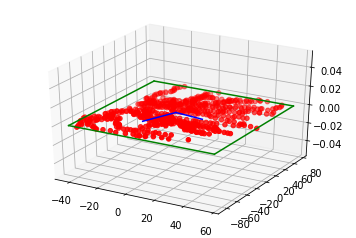

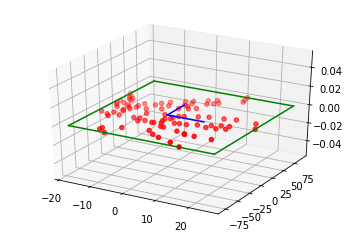

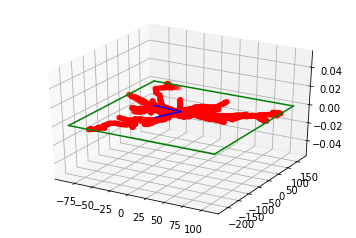

In [6]:
# Let's take a look at some neuron dendritic point clouds.

def plot_cloud(pc):
    pc.pca_bounding()
    fig, ax = plot_bounds(pc.ub, pc.lb, first=True, show=False)
    plot_pc_with_eigenvector(pc.xy_center, pc.eigenvalues, pc.eigenvectors, fig=fig, ax=ax, first=False, show=True)

def plot_clouds(keys, pc_dict, num_to_plot=3):
    for i in range(0, num_to_plot):
        kpos = np.random.randint(low=0, high=len(labs))
        tkey = keys[kpos] 
        tswc_list = pc_dict[tkey] # Extract swc files from lab
        cpos = np.random.randint(low=0, high=len(tswc_list))
        tpc = tswc_list[cpos]
        plot_cloud(tpc)

plot_clouds(labs, cloud_dictionary, num_to_plot=3)




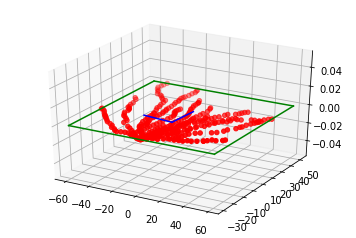

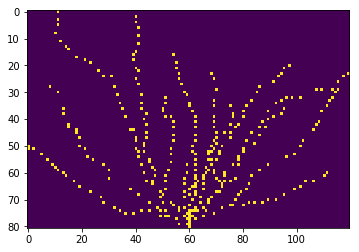

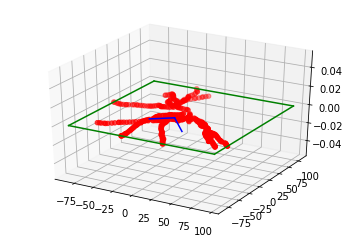

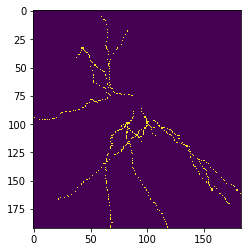

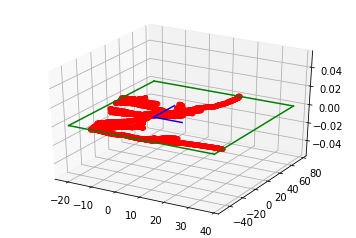

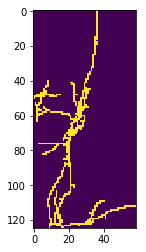

In [7]:
# Now let's conver the point clouds in a numpy 2D array where the presence of a 'dendrite' is given a 1.
# This will serve as our training images

def show_pc(pc):
    pc.pca_bounding()
    fig, ax = plot_bounds(pc.ub, pc.lb, first=True, show=False)
    plot_pc_with_eigenvector(pc.xy_center, pc.eigenvalues, pc.eigenvectors, fig=fig, ax=ax, first=False, show=True)

def show_imgs(keys, pc_dict, num_to_plot=3):
    count = 0
    while count < num_to_plot:
        kpos = np.random.randint(low=0, high=len(labs))
        tkey = keys[kpos] # Grab the name of the first lab as key
        tswc_list = pc_dict[tkey] # Extract swc files from lab
        cpos = np.random.randint(low=0, high=len(tswc_list))
        tpc = tswc_list[cpos] # Grab the first swc to visualize
        dend_center = tpc.center_pc(mod=False)
        img, valid = coord_to_img(dend_center)
        if valid:
            count += 1
            show_pc(tpc)
            fig = plt.figure()          
            plt.imshow(img)
        
show_imgs(labs, cloud_dictionary)

# It is quite obvious the quality of the point clouds and converted images varies based on the quality of the 
# imaged neuron. This, most likely, can be attributed to non-standardized methods for extracting neuronal samples.

In [3]:
# I now convert each point cloud to a png and save into the folder 'img-database'. At this stage, preprocessing is complete
# and we can move on to the notebook 'generation.ipynb'

import scipy.misc

def count_to_str(count):
    if count < 10:
        return '00000' + str(count)
    elif count >= 10 and count < 100:
        return '0000' + str(count)
    elif count >= 100 and count < 1000:
        return '000' + str(count)
    elif count >= 1000 and count < 10000:
        return '00' + str(count)
    elif count >= 10000 and count < 100000:
        return '0' + str(count)
    
tic = time.time()

img_list = []
sz = 64
for _, clist in cloud_dictionary.items():
    for pc in clist:
        dend_center = pc.center_pc(mod=False)
        img, valid = coord_to_img(dend_center)
        if valid and np.sum(img) > 100:
            img = scipy.misc.imresize(img, (sz,sz), interp='bilinear')
            img = (img > 0.0).astype(int)
            img_list.append(img)
toc = time.time()
print('Converting images took %0.3f seconds' % (toc-tic))

batch_size = 64
np.random.shuffle(img_list)
test_num = int(0.1*len(img_list))
print(test_num)
testing = img_list[0:test_num]
training = img_list[test_num:-1]
print(len(training), len(testing))
fn_prefix = 'img-'
fn_suffix = '.png'
icount = 0
for test in testing:
    cstr = count_to_str(icount)
    icount += 1
    fn_full = fn_prefix + cstr + fn_suffix
    scipy.misc.imsave('database-imgs-full/' + cell_type + '/test/a/' + fn_full, test)

icount = 0
for train in training:
    cstr = count_to_str(icount)
    icount += 1
    fn_full = fn_prefix + cstr + fn_suffix
    scipy.misc.imsave('database-imgs-full/' + cell_type + '/train/a/' + fn_full, train)

print('done')

/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/shared/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/shared/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Converting images took 11.120 seconds
528
4759 528


/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


done
